# Notebook para o PAN - Atribuição Autoral - 2018

In [1]:
%matplotlib inline
#python basic libs
from __future__ import print_function

from tempfile import mkdtemp
from shutil import rmtree
import os;
from os.path import join as pathjoin;

import re;
import glob;
import json;
import codecs;
from collections import defaultdict;
import pprint;


from pprint import pprint
from time import time
import logging


#data analysis libs
import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import random;

#machine learning libs
#feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#preprocessing and transformation
from sklearn.preprocessing import normalize, MaxAbsScaler, MinMaxScaler;
from sklearn.preprocessing import LabelBinarizer;
from sklearn.decomposition import PCA;
from sklearn.metrics.pairwise import cosine_similarity;


from sklearn.base import BaseEstimator, ClassifierMixin

#classifiers
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.feature_selection import RFE,SelectFpr,SelectPercentile, chi2;

#
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

#model valuation
from sklearn.model_selection import train_test_split;
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score;


In [2]:
import seaborn as sns;
sns.set(color_codes=True);
from pandas.plotting import scatter_matrix

In [3]:
import platform; print(platform.platform())
print("NumPy", np.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
print("seaborn", sns.__version__)

Darwin-17.5.0-x86_64-i386-64bit
NumPy 1.14.2
SciPy 1.0.1
Scikit-Learn 0.19.1
seaborn 0.8.1


### paths configuration

In [4]:
baseDir = '/Users/joseeleandrocustodio/Dropbox/mestrado/02 - Pesquisa/code';

inputDir= pathjoin(baseDir,'pan18aa');
outputDir= pathjoin(baseDir,'out',"oficial");
if not os.path.exists(outputDir):
    os.mkdir(outputDir);

## loading the dataset

In [5]:
def readCollectionsOfProblems(path):
    # Reading information about the collection
    infocollection = path+os.sep+'collection-info.json'
    with open(infocollection, 'r') as f:
        problems  = [
            {
                'problem': attrib['problem-name'],
                'language': attrib['language'],
                'encoding': attrib['encoding'],
            }
            for attrib in json.load(f)
            
        ]
    return problems;

In [6]:
problems = readCollectionsOfProblems(inputDir);

In [7]:
problems[0]

{'encoding': u'UTF-8', 'language': u'en', 'problem': u'problem00001'}

In [8]:
def readProblem(path, problem):
    # Reading information about the problem
    infoproblem = path+os.sep+problem+os.sep+'problem-info.json'
    candidates = []
    with open(infoproblem, 'r') as f:
        fj = json.load(f)
        unk_folder = fj['unknown-folder']
        for attrib in fj['candidate-authors']:
            candidates.append(attrib['author-name'])
    return unk_folder, candidates;

In [9]:
def read_files(path,label):
    # Reads all text files located in the 'path' and assigns them to 'label' class
    files = glob.glob(pathjoin(path,label,'*.txt'))
    texts=[]
    for i,v in enumerate(files):
        f=codecs.open(v,'r',encoding='utf-8')
        texts.append((f.read(),label, os.path.basename(v)))
        f.close()
    return texts

In [10]:
for index,problem in enumerate(problems):
    unk_folder, candidates_folder = readProblem(inputDir, problem['problem']); 
    problem['candidates_folder_count'] = len(candidates_folder);
    problem['candidates'] = [];
    for candidate in candidates_folder:
        problem['candidates'].extend(read_files(pathjoin(inputDir, problem['problem']),candidate));
    
    problem['unknown'] = read_files(pathjoin(inputDir, problem['problem']),unk_folder);    

In [11]:
pd.DataFrame(problems)

,candidates,candidates_folder_count,encoding,language,problem,unknown
0,"[(graceful ones.\n\n""One more,"" Marvelous said...",20,UTF-8,en,problem00001,"[(after all, his best friends. And what in the..."
1,"[(a mission.""\n\nJensen just raises an eyebrow...",5,UTF-8,en,problem00002,"[(“Potter was attractive,” Draco thought, sigh..."
2,[(qui l'avait tué mais tout était de la faute ...,20,UTF-8,fr,problem00003,[(son réveil. Sa main pulse et Draco frotte l'...
3,[(. Le canapé est vide et lorsqu'il passe deva...,5,UTF-8,fr,problem00004,"[(abasourdie.\n\nTout d'abord, elle crut que s..."
4,"[(Eppure lui la mappa l’aveva stampata, dannaz...",20,UTF-8,it,problem00005,[(– Oh. Cazzo.\nSirius era così sconvolto che ...
5,[(Yato ha trovato una lettera sul suo comodino...,5,UTF-8,it,problem00006,"[(così la tua vista, Moony?\n– Cercavo di esse..."
6,[(zmienił zdanie. Niech się stworzonko pobawi....,20,UTF-8,pl,problem00007,"[(dawniej pełna radości i ciepła, a teraz wiec..."
7,"[(Słowem, które Sherlock najczęściej słyszał w...",5,UTF-8,pl,problem00008,"[(, uderzającego o żebra niczym dzwon- niemal ..."
8,[(pero no lo ama como ama a Guignol –explicó e...,20,UTF-8,sp,problem00009,[(–La nariz puntiaguda del elfo casi rozaba el...
9,"[(incapaz de señalar un momento exacto, un pun...",5,UTF-8,sp,problem00010,[(tan parecidas hizo que su trasero latiese de...


In [12]:
#*******************************************************************************************************
import warnings
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


def eval_measures(gt, pred):
    """Compute macro-averaged F1-scores, macro-averaged precision, 
    macro-averaged recall, and micro-averaged accuracy according the ad hoc
    rules discussed at the top of this file.
    Parameters
    ----------
    gt : dict
        Ground truth, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    pred : dict
        Predicted attribution, where keys indicate text file names
        (e.g. `unknown00002.txt`), and values represent
        author labels (e.g. `candidate00003`)
    Returns
    -------
    f1 : float
        Macro-averaged F1-score
    precision : float
        Macro-averaged precision
    recall : float
        Macro-averaged recall
    accuracy : float
        Micro-averaged F1-score
    """

    actual_authors = list(gt.values())
    encoder = LabelEncoder().fit(['<UNK>'] + actual_authors)

    text_ids, gold_authors, silver_authors = [], [], []
    for text_id in sorted(gt):
        text_ids.append(text_id)
        gold_authors.append(gt[text_id])
        try:
            silver_authors.append(pred[text_id])
        except KeyError:
            # missing attributions get <UNK>:
            silver_authors.append('<UNK>')

    assert len(text_ids) == len(gold_authors)
    assert len(text_ids) == len(silver_authors)

    # replace non-existent silver authors with '<UNK>':
    silver_authors = [a if a in encoder.classes_ else '<UNK>' 
                      for a in silver_authors]

    gold_author_ints   = encoder.transform(gold_authors)
    silver_author_ints = encoder.transform(silver_authors)

    # get F1 for individual classes (and suppress warnings):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        f1 = f1_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        precision = precision_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        recall = recall_score(gold_author_ints,
                  silver_author_ints,
                  labels=list(set(gold_author_ints)),
                  average='macro')
        accuracy = accuracy_score(gold_author_ints,
                  silver_author_ints)

    return f1,precision,recall,accuracy


In [13]:
def evaluate(ground_truth_file,predictions_file):
    # Calculates evaluation measures for a single attribution problem
    gt = {}
    with open(ground_truth_file, 'r') as f:
        for attrib in json.load(f)['ground_truth']:
            gt[attrib['unknown-text']] = attrib['true-author']

    pred = {}
    with open(predictions_file, 'r') as f:
        for attrib in json.load(f):
            if attrib['unknown-text'] not in pred:
                pred[attrib['unknown-text']] = attrib['predicted-author']
    f1,precision,recall,accuracy =  eval_measures(gt,pred)
    return f1, precision, recall, accuracy

In [14]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse


class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        """ Mock method. Does nothing.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        self
        """
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

### examinando o parametro min_df isoladamente

In [15]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.05,
                                   max_df=1.0,
                                   norm='l1',
                                   ngram_range=(3,5),
                                   sublinear_tf=True,
                                   smooth_idf=True,
                                   lowercase =False)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA(0.999)),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__min_df':(2,0.01,0.05,0.1)
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=5,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_, best_parameters;

In [189]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...
done in 38.968s
Best score: 0.769
Best parameters set:
	vect__min_df: 0.01

Problem: problem00002,  language: en, 
Performing grid search...
done in 29.814s
Best score: 0.874
Best parameters set:
	vect__min_df: 0.1

Problem: problem00003,  language: fr, 
Performing grid search...
done in 89.584s
Best score: 0.775
Best parameters set:
	vect__min_df: 0.01

Problem: problem00004,  language: fr, 
Performing grid search...
done in 31.481s
Best score: 0.903
Best parameters set:
	vect__min_df: 0.01

Problem: problem00005,  language: it, 
Performing grid search...
done in 91.047s
Best score: 0.743
Best parameters set:
	vect__min_df: 2

Problem: problem00006,  language: it, 
Performing grid search...
done in 33.172s
Best score: 0.970
Best parameters set:
	vect__min_df: 2

Problem: problem00007,  language: pl, 
Performing grid search...
done in 135.618s
Best score: 0.811
Best parameters set:
	vect__min_df: 0.01

Problem: problem00

In [190]:
pd.DataFrame(best_parameters)[['problem','vect__min_df']]

,problem,vect__min_df
0,problem00001,0.01
1,problem00002,0.10
2,problem00003,0.01
3,problem00004,0.01
4,problem00005,2.00
5,problem00006,2.00
6,problem00007,0.01
7,problem00008,0.10
8,problem00009,0.01
9,problem00010,2.00


### analisando os demais parametros

In [16]:
def runML(problem):
    print ("\nProblem: %s,  language: %s, " %(problem['problem'],problem['language']))
    
    train_docs, train_labels, _   = zip(*problem['candidates'])
    problem['training_docs_size'] = len(train_docs);
    test_docs, _, test_filename   = zip(*problem['unknown'])
    
    pipeline = Pipeline([
        ('vect',   TfidfVectorizer(analyzer='char',
                                   min_df=0.01,
                                   max_df=1.0,
                                   norm='l1',
                                   lowercase =False,
                                   sublinear_tf=True)),
        ('dense',  DenseTransformer()),
        ('scaler', MaxAbsScaler()),
        ('transf', PCA()),
        ('clf', LogisticRegression(random_state=0,multi_class='multinomial', solver='newton-cg')),
    ])
    
    
    # uncommenting more parameters will give better exploring power but will
    # increase processing time in a combinatorial way
    parameters = {
        'vect__ngram_range':((2,3),(2,4),(2,5),(3,5)),
        'vect__sublinear_tf':(True, False),
        'vect__norm':('l1','l2'),
        'transf__n_components': (0.1,0.25,0.5,0.75,0.9,0.99),
    }
    
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               cv=3,
                               n_jobs=-1,
                               verbose=False,
                               scoring='f1_macro')
    
    print("Performing grid search...")
    t0 = time()
    grid_search.fit(train_docs, train_labels)
    print("done in %0.3fs" % (time() - t0))

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    train_pred=grid_search.predict(train_docs);
    test_pred=grid_search.predict(test_docs);
    
    
    # Writing output file
    out_data=[]
    for i,v in enumerate(test_pred):
        out_data.append({'unknown-text': test_filename[i],'predicted-author': v})
    answerFile = pathjoin(outputDir,'answers-'+problem['problem']+'.json');
    with open(answerFile, 'w') as f:
        json.dump(out_data, f, indent=4)
    
    
    #evaluation train
    f1,precision,recall,accuracy=evaluate(
                pathjoin(inputDir, problem['problem'], 'ground-truth.json'),
                answerFile)
    
    return {
                'problem-name'  :       problem['problem'],
                "language"      :       problem['language'],
                'AuthorCount'   :       len(set(train_labels)),
                "train_doc_size":       len(train_docs),
                "train_caract_per_doc": sum([len(l) for l in train_docs])/len(train_docs),
                "test_doc_size" :       len(test_docs),
                "test_caract_per_doc":  sum([len(l) for l in test_docs])/len(test_docs),
                
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3),
                
        }, grid_search.cv_results_,best_parameters;

In [485]:
result = [];
cv_result = [];
best_parameters = [];
for problem in problems:
    r, c, b = runML(problem);
    result.append(r);
    cv_result.append(c);
    b['problem'] = problem['problem'];
    best_parameters.append(b);


Problem: problem00001,  language: en, 
Performing grid search...
done in 658.937s
Best score: 0.833
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 5)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00002,  language: en, 
Performing grid search...
done in 123.030s
Best score: 0.971
Best parameters set:
	transf__n_components: 0.75
	vect__ngram_range: (2, 4)
	vect__norm: 'l1'
	vect__sublinear_tf: True

Problem: problem00003,  language: fr, 
Performing grid search...
done in 675.776s
Best score: 0.800
Best parameters set:
	transf__n_components: 0.99
	vect__ngram_range: (2, 3)
	vect__norm: 'l1'
	vect__sublinear_tf: False

Problem: problem00004,  language: fr, 
Performing grid search...
done in 143.218s
Best score: 0.854
Best parameters set:
	transf__n_components: 0.75
	vect__ngram_range: (2, 4)
	vect__norm: 'l2'
	vect__sublinear_tf: True

Problem: problem00005,  language: it, 
Performing grid search...
done in 837.817s
Best score: 0.701
Best parameter

In [486]:
df=pd.DataFrame(result)[['problem-name',
                     "language",
                     'AuthorCount',
                     "train_doc_size","train_caract_per_doc",
                     "test_doc_size", "test_caract_per_doc",
                     'macro-f1','macro-precision','macro-recall' ,'micro-accuracy']]

In [487]:
df

,problem-name,language,AuthorCount,train_doc_size,train_caract_per_doc,test_doc_size,test_caract_per_doc,macro-f1,macro-precision,macro-recall,micro-accuracy
0,problem00001,en,20,140,4327,105,4370,0.643,0.649,0.759,0.676
1,problem00002,en,5,35,4342,21,4296,0.477,0.517,0.517,0.381
2,problem00003,fr,20,140,4492,49,4508,0.641,0.667,0.709,0.653
3,problem00004,fr,5,35,4522,21,4532,0.747,0.767,0.800,0.667
4,problem00005,it,20,140,4720,80,4787,0.481,0.483,0.601,0.600
5,problem00006,it,5,35,4847,46,4765,0.596,0.596,0.697,0.826
6,problem00007,pl,20,140,5145,103,5200,0.465,0.490,0.529,0.534
7,problem00008,pl,5,35,5049,15,5214,0.822,0.800,0.878,0.867
8,problem00009,sp,20,140,4794,117,4788,0.787,0.788,0.858,0.803
9,problem00010,sp,5,35,4955,64,4827,0.832,0.857,0.823,0.875


In [488]:
print(df[["macro-f1"]].reset_index().to_latex(index=False).replace("     "," "))

\begin{tabular}{rr}
\toprule
 index &  macro-f1 \\
\midrule
 0 & 0.643 \\
 1 & 0.477 \\
 2 & 0.641 \\
 3 & 0.747 \\
 4 & 0.481 \\
 5 & 0.596 \\
 6 & 0.465 \\
 7 & 0.822 \\
 8 & 0.787 \\
 9 & 0.832 \\
\bottomrule
\end{tabular}



In [489]:
languages={
    'en':'inglesa',
    'sp':'espanhola',
    'it':'italiana',
    'pl':'polonesa',
    'fr':'francesa'
}

In [492]:
cv_result2 = [];
dfCV = pd.DataFrame();
for i, c in enumerate(cv_result):
    temp = pd.DataFrame(c);
    temp['problem'] = i+1;
    temp['language'] = languages[problems[i]['language']]
    dfCV = dfCV.append(temp);

for p in ['param_transf__n_components',
    'mean_test_score','std_test_score','mean_train_score',   
    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score']:
    dfCV[p]=dfCV[p].astype(np.float32);

    
dfCV =dfCV[[
    'problem',
    'language',
    'rank_test_score',
    'param_transf__n_components',
    'param_vect__ngram_range',
    'param_vect__sublinear_tf',
    'param_vect__norm',
    'mean_test_score',   
    'std_test_score',
    'mean_train_score',   

    'split0_test_score','split0_train_score',
    'split1_test_score','split1_train_score',
    'split2_test_score','split2_train_score',

    'mean_score_time',
    'mean_fit_time',
    'std_fit_time',
    'std_score_time',
    'std_train_score',
]];

dfCV.rename(columns={
    'param_transf__n_components':'PCA_componentes',
    'param_vect__ngram_range':'ngram_range',
    'param_vect__sublinear_tf':'sublinear_tf',
    'param_vect__smooth_idf':'smooth_idf',
    'param_vect__norm':'norm'
},inplace=True);

#print('\',\n\''.join(dfCV.columns))

In [493]:
dfCV.to_csv('PANAA2018_CHAR.csv', index=False)

In [17]:
dfCV = pd.read_csv('PANAA2018_CHAR.csv', na_values='')

In [18]:
(dfCV[dfCV.rank_test_score == 1])[
    ['problem',
     'language',
    'rank_test_score',
    'mean_test_score',
    'std_test_score',
    'ngram_range',
    'sublinear_tf',
     'norm',
    'PCA_componentes']
].sort_values(by=[
    'problem',
    'mean_test_score',
    'ngram_range',
    'sublinear_tf',
    'PCA_componentes'
], ascending=[True, False,False,False,False])

,problem,language,rank_test_score,mean_test_score,std_test_score,ngram_range,sublinear_tf,norm,PCA_componentes
88,1,inglesa,1,0.833299,0.020391,"(2, 5)",True,l1,0.99
188,2,inglesa,1,0.970612,0.033934,"(3, 5)",True,l1,0.99
190,2,inglesa,1,0.970612,0.033934,"(3, 5)",True,l2,0.99
189,2,inglesa,1,0.970612,0.033934,"(3, 5)",False,l1,0.99
184,2,inglesa,1,0.970612,0.033934,"(2, 5)",True,l1,0.99
186,2,inglesa,1,0.970612,0.033934,"(2, 5)",True,l2,0.99
180,2,inglesa,1,0.970612,0.033934,"(2, 4)",True,l1,0.99
182,2,inglesa,1,0.970612,0.033934,"(2, 4)",True,l2,0.99
164,2,inglesa,1,0.970612,0.033934,"(2, 4)",True,l1,0.90
148,2,inglesa,1,0.970612,0.033934,"(2, 4)",True,l1,0.75


In [19]:
dfCV.pivot_table(
            index=['problem','language','PCA_componentes'],
            columns=['norm','sublinear_tf', 'ngram_range'],
            values='mean_test_score'
        )

norm                                     l1                                \
sublinear_tf                          False                                 
ngram_range                          (2, 3)    (2, 4)    (2, 5)    (3, 5)   
problem language  PCA_componentes                                           
1       inglesa   0.10             0.289050  0.213501  0.135221  0.144955   
                  0.25             0.404768  0.475246  0.473339  0.432229   
                  0.50             0.587794  0.633503  0.690323  0.670391   
                  0.75             0.640255  0.734388  0.767228  0.759660   
                  0.90             0.668231  0.783061  0.811412  0.795527   
                  0.99             0.680153  0.786650  0.803554  0.803350   
2       inglesa   0.10             0.484966  0.406753  0.359320  0.316871   
                  0.25             0.760476  0.564762  0.518095  0.487619   
                  0.50             0.885238  0.824286  0.802993  0.802993   
                  0.75             0.883333  0.852857  0.882993  0.882993   
                  0.90             0.883333  0.854762  0.854422  0.882993   
                  0.99             0.883333  0.940136  0.940136  0.970612   
3       francesa  0.10             0.270412  0.167608  0.158879  0.162775   
                  0.25             0.471545  0.475370  0.456113  0.464135   
                  0.50             0.708559  0.756378  0.691395  0.694847   
                  0.75             0.772194  0.746259  0.738214  0.714065   
                  0.90             0.769881  0.768180  0.783741  0.768792   
                  0.99             0.800204  0.781599  0.772483  0.771531   
4       francesa  0.10             0.269841  0.200779  0.232894  0.206111   
                  0.25             0.357857  0.384005  0.455007  0.455007   
                  0.50             0.648866  0.644762  0.630000  0.630000   
                  0.75             0.739932  0.792993  0.854422  0.825034   
                  0.90             0.775238  0.799524  0.796463  0.796463   
                  0.99             0.775238  0.799524  0.825034  0.825034   
5       italiana  0.10             0.251173  0.216178  0.145058  0.139421   
                  0.25             0.418810  0.447969  0.409962  0.396136   
                  0.50             0.628690  0.574171  0.529200  0.546047   
                  0.75             0.659881  0.625617  0.623764  0.624443   
                  0.90             0.660391  0.634120  0.632602  0.619031   
                  0.99             0.653639  0.628810  0.642823  0.651173   
6       italiana  0.10             0.344898  0.241088  0.232344  0.225541   
                  0.25             0.657687  0.464444  0.425714  0.412857   
                  0.50             0.910748  0.875850  0.880272  0.849796   
                  0.75             0.940136  0.909660  0.911565  0.881088   
                  0.90             0.880272  0.940136  0.940136  0.940136   
                  0.99             0.940136  0.970612  0.940136  0.940136   
7       polonesa  0.10             0.292150  0.220749  0.163698  0.178481   
                  0.25             0.651990  0.565428  0.624476  0.639136   
                  0.50             0.713302  0.748078  0.750459  0.739779   
                  0.75             0.750425  0.760068  0.806412  0.791293   
                  0.90             0.782041  0.773350  0.777874  0.770255   
                  0.99             0.782296  0.792517  0.770255  0.770255   
8       polonesa  0.10             0.153095  0.210037  0.143377  0.143377   
                  0.25             0.482944  0.688435  0.470037  0.373095   
                  0.50             0.564372  0.657229  0.567415  0.666191   
                  0.75             0.711905  0.760476  0.632993  0.654422   
                  0.90             0.711905  0.760476  0.678708  0.653946   
                  0.99             0.711905  0.810476  0.810476  0.810476

In [20]:
pd.options.display.precision = 3  
print(u"\\begin{table}[h]\n\\centering\n\\caption{Medida F1 para os parâmetros }")

print(re.sub(r'[ ]{2,}',' ',dfCV[dfCV.PCA_componentes >= 0.99].pivot_table(
        index=['problem','language','sublinear_tf','norm'],
        columns=['ngram_range'],
        values='mean_test_score'
    ).to_latex()))
print ("\label{tab:modelocaracter}")
print(r"\end{table}")

\begin{table}[h]
\centering
\caption{Medida F1 para os parâmetros }
\begin{tabular}{llllrrrr}
\toprule
 & & & ngram\_range & (2, 3) & (2, 4) & (2, 5) & (3, 5) \\
problem & language & sublinear\_tf & norm & & & & \\
\midrule
1 & inglesa & False & l1 & 0.680 & 0.787 & 0.804 & 0.803 \\
 & & & l2 & 0.670 & 0.760 & 0.715 & 0.734 \\
 & & True & l1 & 0.791 & 0.827 & 0.833 & 0.827 \\
 & & & l2 & 0.816 & 0.818 & 0.819 & 0.826 \\
2 & inglesa & False & l1 & 0.883 & 0.940 & 0.940 & 0.971 \\
 & & & l2 & 0.883 & 0.879 & 0.940 & 0.940 \\
 & & True & l1 & 0.883 & 0.971 & 0.971 & 0.971 \\
 & & & l2 & 0.910 & 0.971 & 0.971 & 0.971 \\
3 & francesa & False & l1 & 0.800 & 0.782 & 0.772 & 0.772 \\
 & & & l2 & 0.794 & 0.761 & 0.732 & 0.724 \\
 & & True & l1 & 0.778 & 0.788 & 0.762 & 0.775 \\
 & & & l2 & 0.786 & 0.769 & 0.763 & 0.776 \\
4 & francesa & False & l1 & 0.775 & 0.800 & 0.825 & 0.825 \\
 & & & l2 & 0.744 & 0.800 & 0.854 & 0.854 \\
 & & True & l1 & 0.744 & 0.800 & 0.854 & 0.854 \\
 & & & l2 & 0.799 &

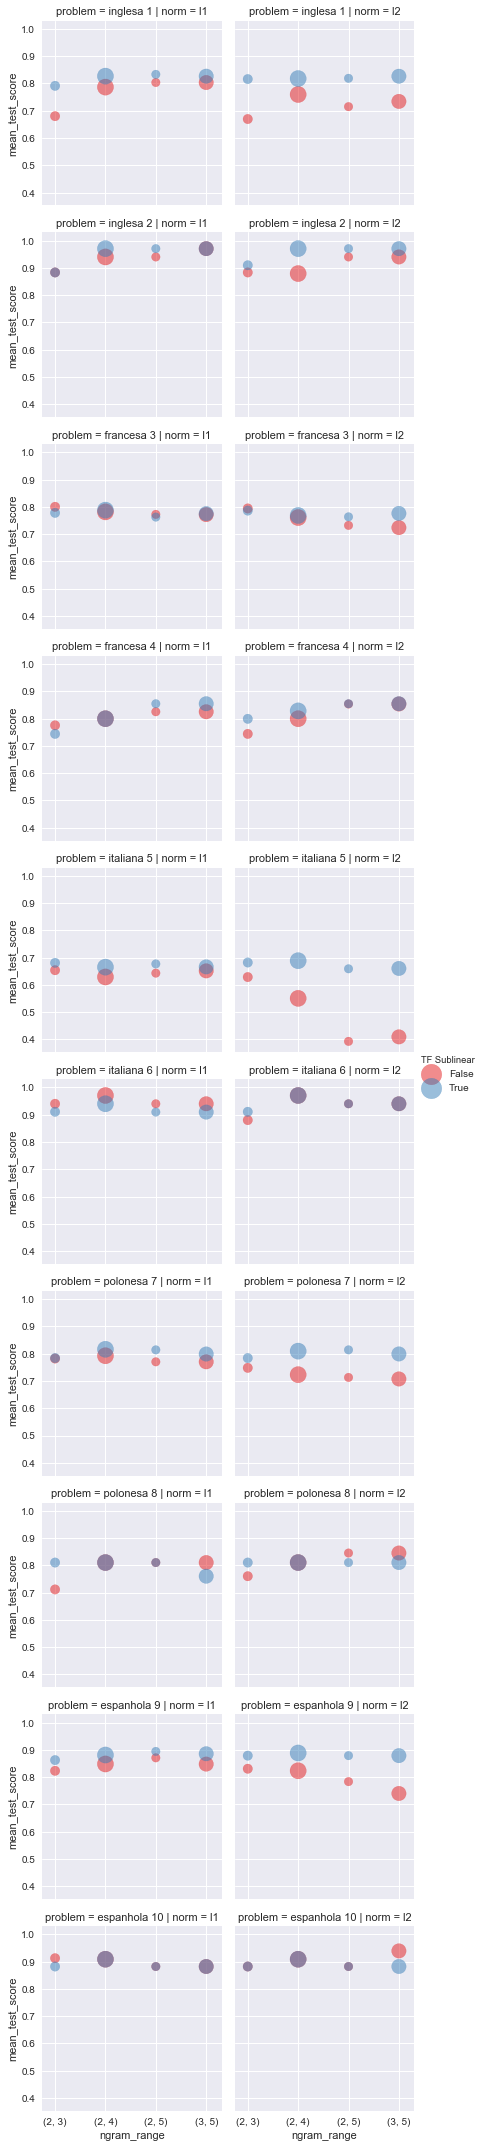

In [21]:
d = dfCV[dfCV.PCA_componentes > 0.9].rename(columns={'language':u'Língua', 'sublinear_tf':'TF Sublinear'})
d = d [ d.norm.isna() == False]
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.problem = d.apply(lambda x: x[u'Língua'] +" "+ str(x[u'problem']), axis=1)
d.std_test_score =d.std_test_score / d.std_test_score.quantile(0.95) *500;
d.std_test_score +=1;
d.std_test_score = d.std_test_score.astype(np.int64)
g = sns.FacetGrid(d, row='problem', hue='TF Sublinear',  col="norm", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

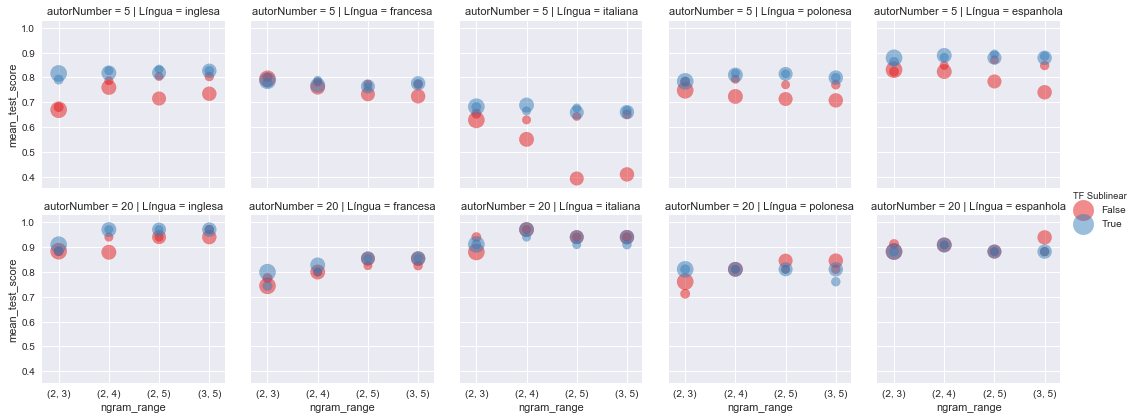

In [22]:
g = sns.FacetGrid(d, row='autorNumber', hue='TF Sublinear',  col=u"Língua", size=3,palette="Set1")
g.map(plt.scatter, "ngram_range", "mean_test_score", alpha=0.5, s=d.std_test_score.values).add_legend();

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


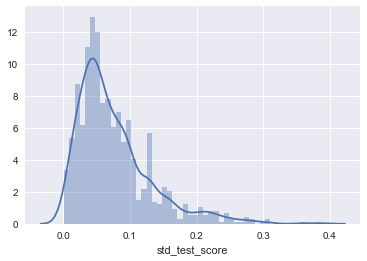

In [23]:
sns.distplot(dfCV.std_test_score, bins=50);

In [24]:
import statsmodels.api as sm

/Users/joseeleandrocustodio/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [30]:
d = dfCV[['mean_test_score','problem', 'language','sublinear_tf','norm','ngram_range','PCA_componentes']].copy();
d.sublinear_tf=d.sublinear_tf.apply(lambda x: 1 if x else 0)
d['autorNumber'] = d.problem.map(lambda x: 20 if x % 2==0  else 5)
d.norm.fillna(value='None', inplace=True);
d.PCA_componentes = np.log(d.PCA_componentes);

_, d['ngram_max'] = zip(*d.ngram_range.str.replace(r'[^\d,]','').str.split(',').values.tolist())
#d.ngram_min = d.ngram_min.astype(np.uint8);
d.ngram_max = d.ngram_max.astype(np.uint8);
d.drop(columns=['ngram_range','problem'], inplace=True)
#d['intercept'] = 1;

d=pd.get_dummies(d, columns=['language', 'norm'])

In [31]:
d.describe()

,mean_test_score,sublinear_tf,PCA_componentes,autorNumber,ngram_max,language_espanhola,language_francesa,language_inglesa,language_italiana,language_polonesa,norm_l1,norm_l2
count,960.000,960.0,960.000,960.000,960.00,960.0,960.0,960.0,960.0,960.0,960.0,960.0
mean,0.626,0.5,-0.798,12.500,4.25,0.2,0.2,0.2,0.2,0.2,0.5,0.5
std,0.239,0.5,0.815,7.504,0.83,0.4,0.4,0.4,0.4,0.4,0.5,0.5
min,0.099,0.0,-2.303,5.000,3.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.447,0.0,-1.386,5.000,3.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.693,0.5,-0.490,12.500,4.50,0.0,0.0,0.0,0.0,0.0,0.5,0.5
75%,0.810,1.0,-0.105,20.000,5.00,0.0,0.0,0.0,0.0,0.0,1.0,1.0
max,0.971,1.0,-0.010,20.000,5.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [32]:
mod = sm.OLS( d.iloc[:,0], d.iloc[:,1:])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        mean_test_score   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     477.2
Date:                Wed, 16 May 2018   Prob (F-statistic):               0.00
Time:                        23:03:41   Log-Likelihood:                 832.60
No. Observations:                 960   AIC:                            -1645.
Df Residuals:                     950   BIC:                            -1597.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
sublinear_tf           0.0681      0.007     10.323      0.000       0.055       0.081
PCA_componentes        0.2520      0.004     62.247      0.000       0.244       0.260
autorNumber            0.0050      0.000     11.390      0.000       0.004       0.006
ngram_max             -0.0312      0.004     -7.839      0.000      -0.039      -0.023
language_espanhola     0.2755      0.008     32.479      0.000       0.259       0.292
language_francesa      0.2230      0.008     26.300      0.000       0.206       0.240
language_inglesa       0.2726      0.008     32.149      0.000       0.256       0.289
language_italiana      0.2418      0.008     28.509      0.000       0.225       0.258
language_polonesa      0.2197      0.008     25.910      0.000       0.203       0.236
norm_l1                0.6440      0.014     46.905      0.000       0.617       0.671
norm_l2                0.5887      0.014     42.877      0.000       0.562       0.616
==============================================================================
Omnibus:                       20.597   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.538
Skew:                          -0.293   Prob(JB):                     7.74e-06
Kurtosis:                       3.495   Cond. No.                     1.18e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.56e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

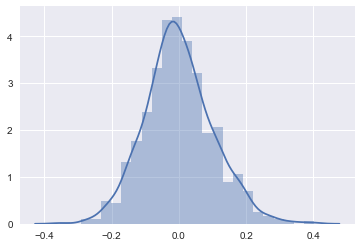

In [28]:
sns.distplot(res.predict()-d.iloc[:,0].values, bins=25)

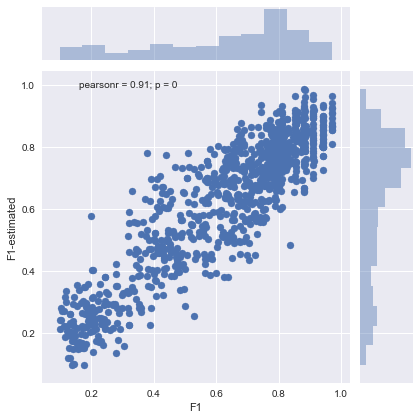

In [29]:
sns.jointplot(x='F1',y='F1-estimated',data=pd.DataFrame({'F1':d.iloc[:,0].values, 'F1-estimated':res.predict()}));

<br/><br/><br/><br/><br/>

#  Abordagem desafiante 1

In [ ]:
from gensim.models import Word2Vec;

In [517]:
%%writefile  NgramSpliter.py
class NgramSplitter(object):
    def __init__(self, text, ngram=(3,3), vocabulary=None):
        self.text = text
        self.ngram_min = ngram[0]
        self.ngram_max = ngram[1];
        self.vocabulary = vocabulary;
    
    def text2ngrams(self,text):
        vect = [
            text[t:t+j]
                for t in xrange(len(text)-self.ngram_max+1)
                for j in xrange(self.ngram_min, self.ngram_max+1)
        ]
        
        if self.vocabulary is not None:
            return [word for word in vect if word in self.vocabulary];
        else:
            return [word for word in vect if word]
 
    def __iter__(self):
        if isinstance(self.text,list):
            for s in self.text:
                yield self.text2ngrams(s);
        elif isinstance(self.text,str) or isinstance(self.text,unicode):
            yield self.text2ngrams(self.text);
            


Writing NgramSpliter.py


In [ ]:
class Word2VecClassifier(BaseEstimator, ClassifierMixin):  
    """A classifier that uses classes embeddings to classify instances"""

    
    def __init__(
            self,
            ngram = (3,4),
            analyzer = 'char',
            min_df = 0.3,
            max_df = 1.0,
        
            min_count =2,
            embeddingSize =750,
            window=10,
            algorithm = 0,
            iter =10
        ):
        """
        Called when initializing the classifier
        """
        self.algorithm     = algorithm
        self.min_count     = min_count
        self.embeddingSize = embeddingSize
        self.window        = window
        self.iter          = iter
        self.analyzer      = analyzer
        self.vocabulary_   = {}
        self.ngram         = ngram
        self.min_df        = min_df
        self.max_df        = max_df

    def _buildVectorModel(self, document):
        sentenseGenerator = NgramSplitter(document,self.ngram, self.vocabulary_);
        
        model = Word2Vec(
            sentenseGenerator,
            sg       = self.algorithm,
            iter     = self.iter,        
            min_count= self.min_count,
            window   = self.window,
            size     = self.embeddingSize,
            seed=0
        );
        return model.wv;
        
    def fit(self, X, y=None):
        """
        Sumarize one text per labels and transform the text into word vectors
        """
        
        #creating author profile
        profile = defaultdict(unicode);
        for text, label in zip(X,y):
            profile[label]+=text;
            
        #build a global vocaculary / Using count vectorizer to create a fixed vocabulary
        vectorizer = CountVectorizer(
                analyzer=self.analyzer,
                ngram_range=self.ngram,
                min_df=self.min_df,
                max_df=self.max_df,
                lowercase=False
        )
        vectorizer.fit(X);
        self.vocabulary_ = vectorizer.vocabulary_
        
        # profile vector represent each author in the embedding space
        self.profileVectors_ = {y: self._buildVectorModel(profile[y]) for y in y};

        return self
    
    
    def _minmax(self, a):
        a = (a - a.min())/(a.max() - a.min());
        return a;
        
    def _simpleCosine(self,a, b):
        '''
        calculates cosine between array a and b.
        This function is used because sklearn similiraty function compares all elements vs all elements
        what will not be used. So this function becames handy.
        '''
        a = a / np.sqrt(np.sum(a **2));
        b = b / np.sqrt(np.sum(b **2));
        cos = np.sum(np.array(a) * np.array(b));
        return cos;
    
    def _KLD(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        
        cond = ((q != 0)&(p != 0));
        k1 = np.sum(np.where(cond, p * np.log(p / q), 0));
        return k1;
    
    def _manhattan(self,p, q):
        p = self._minmax(p); p = p/p.sum();
        q = self._minmax(q); q = q/q.sum();
        return np.mean(np.abs(p-q));
    
    
    def _guassian(self, C,D):
        cond = C-D !=0;
        bc = np.where(cond,(C-D+1)**2/(2*np.maximum(C,D+1)),1);
        return np.sum(-np.log(bc));


    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X)))
    
    def _softMax(self,a):
        a = self._minmax(a);
        a = np.exp(a)/np.sum(np.exp(a))
        return a;
    
    def _predict1Doc(self, docVect):
        vocabDoc = set(docVect.vocab.keys());
    
        metrics = [];
        
        def c(aa,bb, funct):
            voc = set(aa.vocab.keys()) & set(bb.vocab.keys())
            f = np.array([
                funct(aa[v], bb[v])
                for v in voc
            ]);
            f = np.sum(f)
            return f;
    
        for label in self.profileVectors_:
            labelVocab = set(self.profileVectors_[label].vocab.keys());
            intersect  = vocabDoc & labelVocab;
            union      = len(vocabDoc | labelVocab);
            jaccard    = 1.0*len(intersect) / union;
            
            metrics.append({
                'label'       : label,
                'jaccard'     : jaccard,
                'lenIntersect': len(intersect),
                'lenUnion'    : union,
                'lenMax'      : max(len(labelVocab), len(vocabDoc)),
                'similarity'  : c(docVect, self.profileVectors_[label], self._simpleCosine),
                'KLD'         : c(docVect, self.profileVectors_[label], self._KLD),
                'manhattan'   : c(docVect, self.profileVectors_[label], self._manhattan),
                'guassian'    : c(docVect, self.profileVectors_[label], self._guassian),
                
            })
        #softmax norm
        similarity = self._softMax(np.array([c['similarity'] for c in metrics ]));
        guassian   = self._softMax(np.array([c['guassian'] for c in metrics ]));
        manhattan  = self._softMax(np.array([c['manhattan'] for c in metrics ]));
    
        #appending normalized sum of distance
        for i,c in enumerate(metrics):
            c.update({
                'similarityNorm': similarity[i],
                'guassianNorm': guassian[i],
                'manhattanNorm': manhattan[i]
            })
    
        return metrics;
    
    def predict(self, X, y=None):
        try:
            getattr(self, "profileVectors_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
            
        docVectors    = [self._buildVectorModel(x) for x in X];
        self.metrics_ = [self._predict1Doc(v)      for v in docVectors];
        
        result = [];
        for r in self.metrics_:
            best = r[0];
            best['bestMatch'] = True;
            for rr in r:
                if rr != best:
                    rr['bestMatch'] = False;
                if rr['similarityNorm'] > best['similarityNorm'] :
                    best['bestMatch'] = False;
                    best = rr;
                    best['bestMatch'] = True;
            result.append(best);
            
        self.predited_ = result;

        return([r['label'] for r in result])

In [ ]:
problem = problems[8];
print ("Problem: %s,  language: %s, " %(problem['problem'],problem['language']))

In [ ]:
model = Word2VecClassifier();

In [ ]:
train_docs, train_labels,_ = zip(*problem['candidates']);

In [ ]:
model.fit(train_docs,train_labels);

In [ ]:
trainPred = model.predict(train_docs);
trainMetrics = model.metrics_;

In [ ]:
df=pd.DataFrame(zip(train_labels,trainPred), columns=['label','pred'])
df.label = df.label.apply(lambda x: int(re.sub(r'\D','',x)));
df.pred = df.pred.apply(lambda x: int(re.sub(r'\D','',x)));
df.plot.scatter(x='label',y='pred');

In [ ]:
m  = trainMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'manhattan'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(trainMetrics)
df[df.doc == 55]

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
model.get_params()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')
df[df.solution == df.label].plot.scatter(x='manhattanNorm', y='guassianNorm', c='distance',colormap='Reds')

### test

In [ ]:
#code from baseline
gt = {}
with open(pathjoin(inputDir, problem['problem'], 'ground-truth.json'), 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

In [ ]:
test_docs, _, test_filename = zip(*problem['unknown'])
test_labels = [gt[v] for v in test_filename]

In [ ]:
testPred = model.predict(test_docs);
testMetrics = model.metrics_;

In [ ]:
m  = testMetrics
df = pd.DataFrame([item for s in m for item in s])
df['doc']      = [i               for i,s in enumerate(m) for item in s]
df['solution'] = [train_labels[i] for i,s in enumerate(m) for item in s]
df.sort_values(by=['doc','similarityNorm', 'KLD'], ascending=[True,False,True], inplace=True)
df['distance'] = [i for i in range(len(set(train_labels)))]* len(testMetrics)
df[df.doc == 55]

In [ ]:
f1,precision,recall,accuracy =  eval_measures(gt,{k: v for k,v in zip(test_filename, testPred)  })

In [ ]:
pd.DataFrame([{
                'macro-f1'       : round(f1,3),
                'macro-precision': round(precision,3),
                'macro-recall'   : round(recall,3),
                'micro-accuracy' : round(accuracy,3)
             }])

In [ ]:
df2 = df[df.bestMatch].copy();
df2['correct'] = df2.apply(lambda x: x['label'] == x['solution'], axis=1)
df2[['correct','doc']].groupby(by='correct').count()

In [ ]:
df[df.solution == df.label].plot.scatter(x='distance', y='guassianNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='manhattanNorm')
df[df.solution == df.label].plot.scatter(x='distance', y='similarityNorm')

In [ ]:
df[df.solution == df.label]\
    .plot\
    .scatter(
        x='guassianNorm',
        y='similarityNorm',
        c='distance',
        colormap='Reds',
        figsize=(20,5));